# Chapter 6

## Exercise 8

### (a)

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(100)
n=100
X=np.random.normal(loc=0,scale=1,size=n)
epsilon=np.random.normal(loc=0,scale=1,size=n)

### (b)

In [3]:
beta=np.array([0.2,1,1.5,4])
Y=beta[0]+beta[1]*X+beta[2]*X**2+beta[3]*X**3+epsilon

### (c)

In [4]:
Xs=pd.DataFrame({'X':X,'X2':X**2,'X3':X**3,'X4':X**4,'X5':X**5,'X6':X**6,'X7':X**7,'X8':X**8
                ,'X9':X**9,'X10':X**10})
Ys=pd.DataFrame({'Y':Y})
def nCp(sigma2, estimator, Xsigma, Ysigma):
    "Negative Cp statistic"
    n, p = Xsigma.shape
    Yhat = estimator.predict(Xsigma)
    RSS = np.sum((Ysigma - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n #We look for the negative Cp since the sklearn methods try to 
#maximize the ouputs
#Let's now compute the residual variance sigma2. i.e, the variance of the residuals of 
#the complete model
design = MS(Xs).fit(Xs)
Ysigma = np.array(Ys['Y'])
Xsigma = design.transform(Xs)
model=OLS(Ysigma,Xsigma).fit()
sigma2 = model.scale#The result should be close enough to 1 because the beta 
#coefficients are close too and the Xs columns are generated from a standard normal distribution

#Now we should specify the strategy for the selection of the best model. For this we gonna use 
#Stepwise.first_peak() method available in ISLP library
strategy=Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))
#Now it's time to fit a linear regression model using the strategy and the sklearn_selected() from
#the ISLP.models package. But before we should freeze the first argument 
neg_Cp = partial(nCp,sigma2) 
Y_Cp= sklearn_selected(OLS,strategy,scoring=neg_Cp)
Y_Cp.fit(Xsigma, Ysigma)
Y_Cp.selected_state_

('X', 'X2', 'X3')

### (d)

In [5]:
strategy_backward=Stepwise.first_peak(design,direction='backwards',max_terms=len(design.terms))
neg_Cp1 = partial(nCp,sigma2) 
Y_CpB= sklearn_selected(OLS,strategy_backward,scoring=neg_Cp1)
Y_CpB.fit(Xsigma, Ysigma)
Y_CpB.selected_state_

('X', 'X2', 'X3')

Logically we get the same results as for forward stepwise selection. As a reminder the choice of X, X2 and X3 does not mean that the related regression coefficients are significant as regularization methods merely suggest candidates for the optimal model.

### (e)

In [6]:
#No need to standardise Xs columns because they already stem from standard normal distribution
D = design.fit_transform(Xs)
X1 = np.asarray(D)
# Since we want to use a Lasso model there is no need to specify a grid of lambdas. These will be
# be generated automatically
scaler = StandardScaler(with_mean=True,  with_std=True)
K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)
lassoCV = skl.ElasticNetCV(n_alphas=100,l1_ratio=1,cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),('lasso', lassoCV)])
pipeCV.fit(X1, Ysigma)
tuned_lasso = pipeCV.named_steps['lasso']

print('The optimal value of lambda is:',tuned_lasso.alpha_)

The optimal value of lambda is: 0.011422938509194142


In [7]:
#Fit a path of Lasso regressions and extract lambdas as well cause these are generated automtically
# for the Lasso model case
lambdas, soln_array = skl.Lasso.path(Xsigma,Ysigma,l1_ratio=1,n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,columns=D.columns,index=-np.log(lambdas))

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.934367513687448, tolerance: 1.1799785047679547
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.527131237550748, tolerance: 1.1799785047679547
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.425192897651414, tolerance: 1.1799785047679547
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppDa

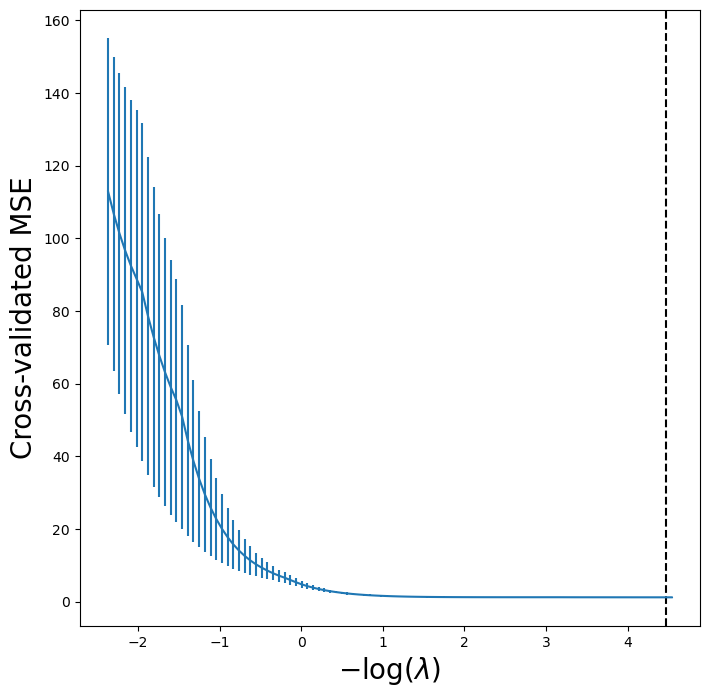

In [8]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [9]:
# Now let's report the corresponding coefficients of the optimal lambda chosen by cross validation
tuned_lasso.coef_


array([ 0.00000000e+00,  7.23101437e-01,  1.56911795e+00,  1.06337083e+01,
        2.77621504e-01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -4.86290744e-03,  0.00000000e+00])

The best model according to Lasso regression contains the coefficients of $X$, $X^2$, $X^3$, $X^4$ and $X^9$. Notice that results obtained by Lasso are different than those obtained by stepwise or backward selection.<br>
This was expected as the latter two methods are greedy algorithms and merely find a local subset, which is different for Lasso.

### (f)

In [10]:
X.shape

(100,)

In [11]:
beta=[6,10]
Ynew=beta[0]+beta[1]*X**7+epsilon

In [12]:
#Run the forward stepwise selection approach with the same predictors as the previous models
Ysnew=pd.DataFrame({'Y':Ynew})
design = MS(Xs).fit(Xs)
Ysigman = np.array(Ysnew['Y'])
model=OLS(Ysigman,Xsigma).fit()
sigma2n = model.scale
strategy=Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))
neg_Cpn = partial(nCp,sigma2n) 
Y_Cpn= sklearn_selected(OLS,strategy,scoring=neg_Cpn)
Y_Cpn.fit(Xsigma, Ysigman)
Y_Cpn.selected_state_

('X7',)

The forward stepwise selection approach recommands the model containing predictor $X^7$ and the intercept as the best one.<br>
The stepwise selection seucceeded in this case to emulate the true model.

In [13]:
# Let's run the Lasso regrssion
scaler = StandardScaler(with_mean=True,  with_std=True)
K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)
lassoCVn = skl.ElasticNetCV(n_alphas=100,l1_ratio=1,cv=kfold)
pipeCVn = Pipeline(steps=[('scaler', scaler),('lasso', lassoCV)])
pipeCVn.fit(X1, Ysigman)
tuned_lasson = pipeCVn.named_steps['lasso']

print('The optimal value of lambda is:',tuned_lasso.alpha_)

The optimal value of lambda is: 0.6268263569044815


In [14]:
tuned_lasson.coef_

array([  0.        ,  -2.74928715,   0.53179374,   0.        ,
         0.        ,  76.93506706,   0.        , 435.77147222,
         0.        , 118.82385473,  -0.        ])

## Exercise 9

In [15]:
college=load_data('College')

In [16]:
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(16), object(1)
memory usage: 

In [17]:
college

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
773,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
774,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
775,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


The predictors dataframe should contain all the columns except the Apps column dedicated for the output. However, Ridge and Lasso regressions, which will be used later in this exercise entail the normalization of varaibles. Such normalization is handled as far as categorical variables are concerned as it is shown in the lab.

In [18]:
college.Private.astype('category')

0      Yes
1      Yes
2      Yes
3      Yes
4      Yes
      ... 
772     No
773    Yes
774    Yes
775    Yes
776    Yes
Name: Private, Length: 777, dtype: category
Categories (2, object): ['No', 'Yes']

### (a)

In [19]:
college_train,college_test = train_test_split(college,test_size=0.5,random_state=0)
college_train['Private01']=np.where(college_train['Private']=='Yes',1,0)
college_test['Private01']=np.where(college_test['Private']=='Yes',1,0)

### (b)

In [20]:
design = MS(college.columns.drop(['Apps','Private'])).fit(college)
X_train = design.transform(college_train)
y_train=college_train['Apps']
result=OLS(y_train,X_train).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Apps   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     292.4
Date:                Sat, 16 Sep 2023   Prob (F-statistic):          4.67e-199
Time:                        12:21:30   Log-Likelihood:                -3251.6
No. Observations:                 388   AIC:                             6537.
Df Residuals:                     371   BIC:                             6604.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept   -1112.5384    552.802     -2.013      0.045   -2199.557     -25.520
Accept          1.2854      0.068     18.832      0.000       1.151       1.420
Enroll         -0.2739      0.253     -1.081      0.280      -0.772       0.224
Top10perc      57.7756      8.176      7.067      0.000      41.699      73.852
Top25perc     -21.9565      6.595     -3.329      0.001     -34.925      -8.988
F.Undergrad     0.0934      0.043      2.195      0.029       0.010       0.177
P.Undergrad     0.0408      0.040      1.017      0.310      -0.038       0.120
Outstate       -0.0657      0.027     -2.474      0.014      -0.118      -0.013
Room.Board      0.1635      0.072      2.274      0.024       0.022       0.305
Books          -0.0654      0.320     -0.204      0.838      -0.695       0.564
Personal       -0.0505      0.088     -0.572      0.568      -0.224       0.123
PhD            -8.3451      7.720     -1.081      0.280     -23.526       6.835
Terminal        0.6134      8.510      0.072      0.943     -16.120      17.347
S.F.Ratio      25.8068     17.667      1.461      0.145      -8.933      60.547
perc.alumni    -9.7264      6.317     -1.540      0.124     -22.148       2.695
Expend          0.0809      0.020      4.079      0.000       0.042       0.120
Grad.Rate      10.9956      4.346      2.530      0.012       2.449      19.542
==============================================================================
Omnibus:                      217.309   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2145.651
Skew:                           2.186   Prob(JB):                         0.00
Kurtosis:                      13.659   Cond. No.                     1.69e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
design_test=MS(college.columns.drop(['Private','Apps'])).fit(college)
X_test=design_test.transform(college_test)
Y_hat=result.predict(X_test)
MSE_ols=np.mean((Y_hat-college_test['Apps'])**2)
print('The obtained test error for the least squares linear model is ',MSE_ols)

The obtained test error for the least squares linear model is  1244800.2699891967


### (c)

In [22]:
# Choose the optimal lambda for ridge regression on the training set
K = 10
kfold = skm.KFold(K,random_state=0,shuffle=True)
lambdas = 10**np.linspace(8, -2, 100) / college['Apps'].std()
param_grid = {'ridge__alpha': lambdas}
ridge = skl.ElasticNet(alpha=lambdas[9], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
grid = skm.GridSearchCV(pipe,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
grid.best_params_['ridge__alpha']

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.649e+09, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e+09, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e+09, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.549e+09, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.649e+09, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.812e+09, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e+09, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.549e+09, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.812e+09, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.563e+09, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+09, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.606e+09, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.646e+09, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e+09, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e+09, tolerance: 5.138e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.729e+09, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+09, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.543e+09, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.472e+09, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.670e+09, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.465e+09, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+09, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.455e+09, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.653e+09, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.519e+09, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+09, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.578e+09, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.735e+09, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.483e+09, tolerance: 5.138e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.639e+09, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.541e+09, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.470e+09, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.581e+09, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.355e+09, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.458e+09, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.514e+09, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e+09, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e+09, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e+09, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.016e+09, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e+09, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e+09, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e+09, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e+09, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e+09, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e+09, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e+09, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e+09, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+09, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+09, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.651e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.430e+08, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.396e+08, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.240e+08, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.270e+08, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.134e+08, tolerance: 5.138e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+08, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.209e+08, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.123e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+08, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.886e+08, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.130e+08, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.391e+08, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.074e+08, tolerance: 5.138e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.998e+08, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.975e+08, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.674e+08, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.555e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.450e+08, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e+08, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.347e+08, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e+08, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e+08, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.147e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e+08, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e+08, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e+08, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e+08, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.157e+08, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e+08, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e+08, tolerance: 5.138e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e+08, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e+08, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e+08, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e+08, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+08, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e+08, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e+08, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+08, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e+08, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e+08, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e+08, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e+08, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.069e+08, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e+08, tolerance: 5.138e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e+08, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e+08, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e+08, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e+08, tolerance: 5.626e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e+08, tolerance: 5.128e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e+08, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e+08, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e+08, tolerance: 5.217e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+08, tolerance: 5.099e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e+08, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+08, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e+08, tolerance: 5.595e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+08, tolerance: 5.300e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e+08, tolerance: 5.138e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e+08, tolerance: 5.467e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e+08, tolerance: 4.965e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+08, tolerance: 5.364e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e+08, tolerance: 5.879e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.007024410108016933

In [23]:
opt_lambda=grid.best_params_['ridge__alpha']

In [24]:
# Fit the ridge regression
ridge_opt = skl.ElasticNet(alpha=opt_lambda, l1_ratio=0)
pipe_ridge = Pipeline(steps=[('scaler', scaler), ('ridge', ridge_opt)])
result_ridge=pipe_ridge.fit(X_train, y_train)

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e+08, tolerance: 5.879e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [25]:
Y_hat_ridge=result_ridge.predict(X_test)
MSE_ridge=np.mean((Y_hat_ridge-college_test['Apps'])**2)
print('The obtained test error for the ridge regression model is ',MSE_ridge)

The obtained test error for the ridge regression model is  1335136.233520605


### (d)

In [26]:
# Choose the optimal lambda for lasso regression on the training set
param_grid_2 = {'lasso__alpha': lambdas}
lasso= skl.ElasticNet(alpha=lambdas[9], l1_ratio=1)
pipe_2 = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
grid_2 = skm.GridSearchCV(pipe_2,param_grid_2,cv=kfold,scoring='neg_mean_squared_error')
grid_2.fit(X_train, y_train)
opt_lambda_lasso=grid_2.best_params_['lasso__alpha']
print('The optimal lmabda chosen for lasso regression is',opt_lambda_lasso )

The optimal lmabda chosen for lasso regression is 9.504362464388217


In [27]:
# Fit the lasso regression
lasso_opt = skl.ElasticNet(alpha=opt_lambda_lasso, l1_ratio=1)
pipe_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', lasso_opt)])
result_lasso=pipe_lasso.fit(X_train, y_train)

In [28]:
Y_hat_lasso=result_lasso.predict(X_test)
MSE_lasso=np.mean((Y_hat_lasso-college_test['Apps'])**2)
print('The obtained test error for the ridge regression model is ',MSE_lasso)

The obtained test error for the ridge regression model is  1274819.306836743


In [29]:
tuned_lasso = pipe_lasso.named_steps['lasso']

In [30]:
tuned_lasso.coef_

array([   0.        , 3116.63401003,   -0.        ,  936.41417856,
       -334.5727745 ,  335.31207055,   58.97120064, -213.10391846,
        161.37116451,   -0.        ,  -23.51599141, -105.54207564,
         -0.        ,   87.14757609, -122.71487843,  378.45990596,
        158.32546935])

The number of non zero coefficients is 15.

### (e)

In [31]:
# Choose the number of components M by cross validation
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
param_grid = {'pca__n_components': range(1, 19)}
pipe_pca=Pipeline(steps=[('scaler', scaler), ('pca', pca),('linreg', linreg)])
grid = skm.GridSearchCV(pipe_pca,param_grid,cv=kfold,scoring='neg_mean_squared_error')
pipe_pca.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('linreg', LinearRegression())])

In [32]:
grid.fit(X_train, y_train)

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-pac

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 19)},
             scoring='neg_mean_squared_error')

In [33]:
n_comp = param_grid['pca__n_components']
df=pd.DataFrame({'num_components':n_comp,'CV_MSE':-grid.cv_results_['mean_test_score']})
M=df['CV_MSE'].argmin(skipna=True)+1
M

16

In [34]:
pca_M = PCA(n_components=M)
linreg = skl.LinearRegression()
param_grid_M = {'pca_M__n_components': range(1, 19)}
pipe_pca_M=Pipeline(steps=[('scaler', scaler), ('pca', pca_M),('linreg', linreg)])
result_pca=pipe_pca_M.fit(X_train, y_train)

The optimal choice for the number of components is 17. The test error for the corresponding is 

In [35]:
Yhat_pca=result_pca.predict(X_test)
MSE_pca=np.mean((Yhat_pca-college_test['Apps'])**2)
print('The obtained test error for the pca model is',MSE_pca)

The obtained test error for the pca model is 1244800.2699891438


### (f)

In [36]:
#Initialize the fit of PLS model
pls = PLSRegression(n_components=2,scale=True)
pls.fit(X_train,y_train)

PLSRegression()

In [37]:
param_grid = {'n_components':range(1, 19)}
grid = skm.GridSearchCV(pls,param_grid,cv=kfold,scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\cross_decomposition\_pls.py", line 660, in fit
    super().fit(X, Y)
  File "C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\cross_decomposition\_pls.py", line 251

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 19)},
             scoring='neg_mean_squared_error')

In [38]:
n_comp = param_grid['n_components']
df=pd.DataFrame({'num_components':n_comp,'CV_MSE':-grid.cv_results_['mean_test_score']})
M=df['CV_MSE'].argmin(skipna=True)+1
M

11

The optimal choice for the number of components as fas PLS is concerned is 12.

In [39]:
#Refit the pls model using the optimal number of components
pls = PLSRegression(n_components=M,scale=True)
result_pls=pls.fit(X_train,y_train)

In [40]:
Yhat_pls=result_pls.predict(X_test)
Y_test=np.asarray(college_test['Apps']).reshape(-1,1)
MSE_pls=np.mean((Yhat_pls-Y_test)**2)
print('The obtained test error for the pca model is',MSE_pls)

The obtained test error for the pca model is 1261711.8358401617


### (g)

In [41]:
# Let's first sum up the obtained results in the previous questions
results_df=pd.DataFrame({'Models':['OLS','Ridge','Lasso','PCR','PLS'],'Test_MSE':
                       [MSE_ols,MSE_ridge,MSE_lasso,MSE_pca,MSE_pls]})
results_df

,Models,Test_MSE
0,OLS,1.244800e+06
1,Ridge,1.335136e+06
2,Lasso,1.274819e+06
3,PCR,1.244800e+06
4,PLS,1.261712e+06


No model has a better test MSE than multiple linear regression using OLS. Hence, it is the best model.

In [42]:
college['Apps'].mean()

3001.6383526383524

In [43]:
RMSE=np.sqrt(results_df['Test_MSE']/college_test.shape[0])
RMSE

0    56.568549
1    58.585210
2    57.246576
3    56.568549
4    56.951516
Name: Test_MSE, dtype: float64

The RMSE of different models, showing the distance around the mean, is low in comparison with this latter. The best model (i.e the OLS model) yield a means error of +/- 57 applications at most which shows an impressively good fit.

All in all, the models have approximately the same values of RMSE. The maximal variation among those models is $(59.037581-56.568549)/56.568549=4.36$%

## Exercise 10

### (a)

In [44]:
np.random.seed(1)
X=pd.DataFrame(np.random.normal(size=(1000, 20)))
column_names=['X'+str(i) for i in range(20)]#Rename the columns because ModelSpec gets confused 
# when column names are integers
X.columns=column_names

In [45]:
epsilon=np.random.normal(1000)

In [46]:
beta=np.zeros(20)
Non_null=[20,15,186,24,659,55,42,789,578,4]
j=0
#Let's make half of beta non null
for i in np.random.choice(range(20), size=10, replace=False):
    beta[i]=Non_null[j]
    j+=1

In [47]:
Y=np.matmul(X,beta)+epsilon
y_df=pd.DataFrame({'Y':Y})

### (b)

In [48]:
df=pd.concat([X,y_df ], axis=1)
df_train,df_test = train_test_split(df,test_size=900,random_state=0)

### (c)

In [49]:
design = MS(df.columns.drop('Y'))

In [50]:
D = design.fit(df)
D=D.transform(df_train)
D = D.drop('intercept', axis=1)#Drop the intercept as the function fit_path used later fits the 
# intercept separately
X_train = np.asarray(D)
Y_train=np.asarray(df_train['Y'])#Beware to check wether the number of dimensions of Y_train is 1
# cause in the opposite case, the fit_path function used next won't work

In [51]:
path = fit_path(X_train,Y_train,max_nonzeros=X_train.shape[1],intercept=False)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  1
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  3
Iteration: 8. Number of non-zeros:  3
Iteration: 9. Number of non-zeros:  5
Iteration: 10. Number of non-zeros:  5
Iteration: 11. Number of non-zeros:  5
Iteration: 12. Number of non-zeros:  6
Iteration: 13. Number of non-zeros:  6
Iteration: 14. Number of non-zeros:  6
Iteration: 15. Number of non-zeros:  6
Iteration: 16. Number of non-zeros:  6
Iteration: 17. Number of non-zeros:  6
Iteration: 18. Number of non-zeros:  6
Iteration: 19. Number of non-zeros:  6
Iteration: 20. Number of non-zeros:  7
Iteration: 21. Number of non-zeros:  7
Iteration: 22. Number of non-zeros:  7
Iteration: 23. Number of non-zeros:  7
Iteration: 24. Number of non-zeros:  12
Iteration: 25. Number of non-zeros:  12

Based on the results of the fit_path we should compare training set MSE for the models with 1, 3, 4, 5, 6, 8, 11, 16 and 20 predictors.<br>
We can choose among any interation number for every type of model, since the fit_path function does not change the regression coefficients, including the intercept coefficient, when the number of predictors remains the same.

In [52]:
iteration=[0,2,4,8,11,19,23,38,39,40]#This is a list which includes the indexes of the returned 
#fit_path in this case, once the number of non-zeros changes
pred_num=[1,2,3,5,6,7,12,18,19,20]
coef_list=[]
for i in iteration:
    #construct a list of arrays. Each array contains the subsets coefficients 
    coef_list.append(path[i]['B'])
Yhat=[]
for i in range(len(iteration)):
    Yhat.append(np.matmul(X_train,coef_list[i]))
MSE=[]
for i in range(len(Yhat)):
    MSE.append(np.mean((Yhat[i]-Y_train)**2))

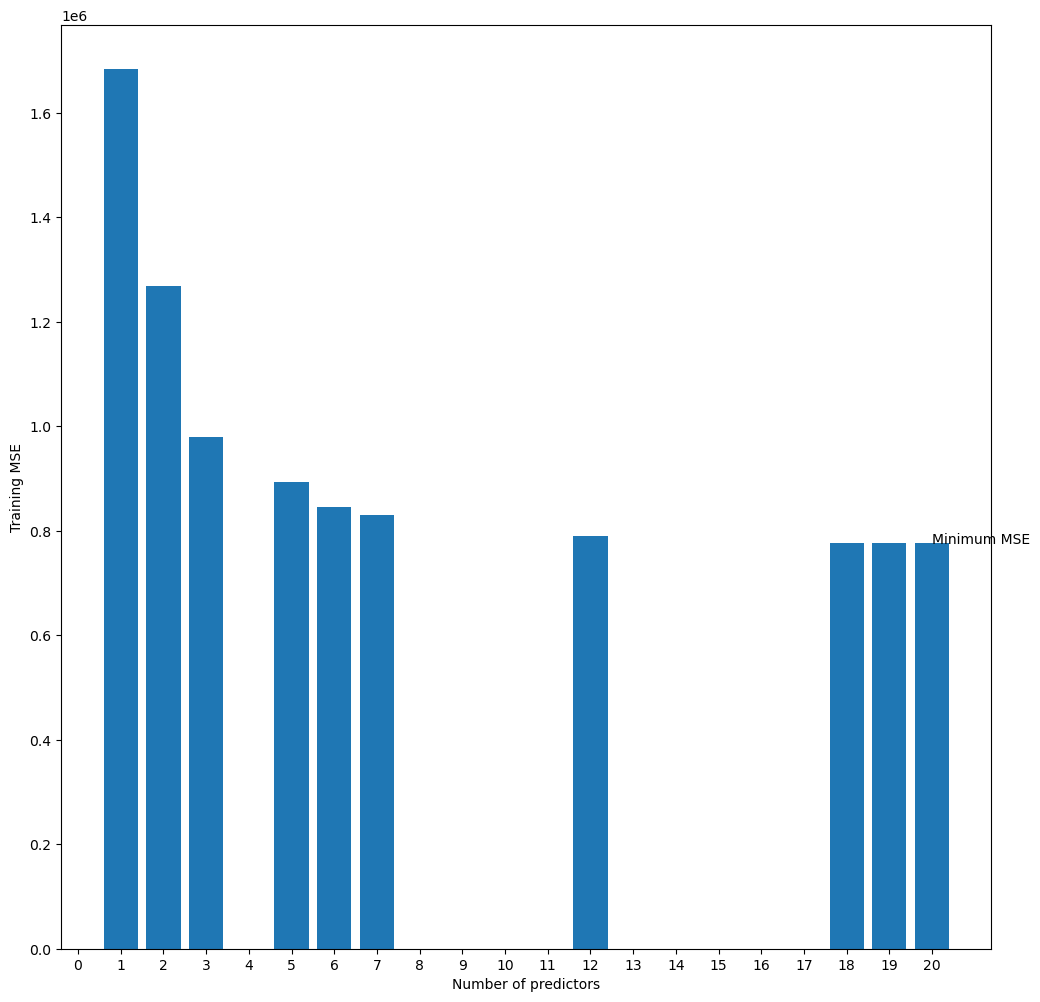

In [53]:
mse_fig, ax = subplots(figsize=(12,12))
ax.bar(pred_num,MSE)
ax.set_ylabel('Training MSE')
ax.set_xlabel('Number of predictors')
ax.set_xticks(np.arange(max(pred_num)+1))
ax.annotate('Minimum MSE',(pred_num[np.argmin(MSE)],min(MSE)));

The minimal training MSE is indicated for 20 predictors.

### (d)

In [54]:
#ones_test=np.ones(900).reshape(-1,1)
X_test=df_test.iloc[:,:-1]
Y_test=df_test['Y']
#Xhat_test=np.append(X_test, ones_test, axis=1)
Yhat_test=[]
for i in range(len(iteration)):
    Yhat_test.append(np.matmul(X_test,coef_list[i]))
MSE_test=[]
for i in range(len(Yhat)):
    MSE_test.append(np.mean((Yhat_test[i]-Y_test)**2))

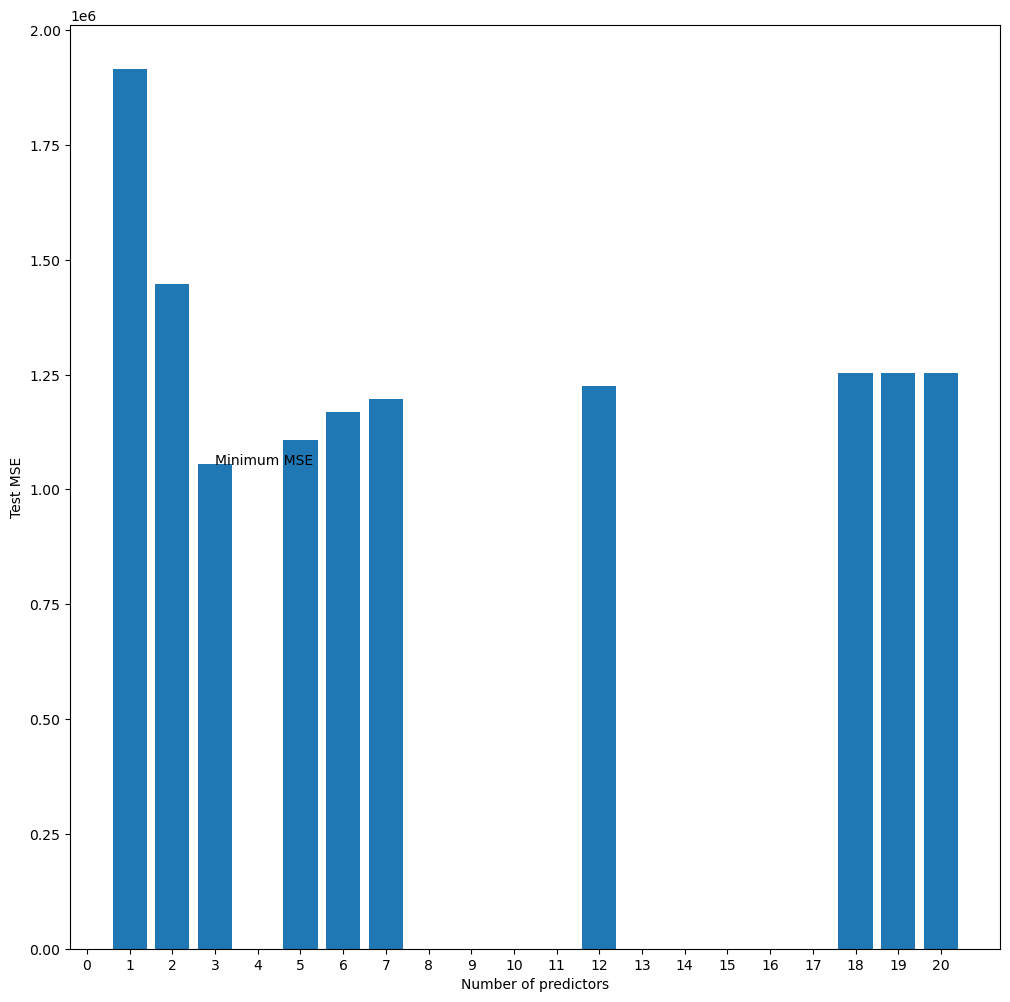

In [55]:
mse_fig1, ax1 = subplots(figsize=(12,12))
ax1.bar(pred_num,MSE_test)
ax1.set_ylabel('Test MSE')
ax1.set_xlabel('Number of predictors')
ax1.set_xticks(np.arange(max(pred_num)+1))
ax1.annotate('Minimum MSE',(pred_num[np.argmin(MSE_test)],min(MSE_test)));

### (e)

In [56]:
path[4]

{'B': array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , 549.9725458 ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , 932.67279087,   0.        ,
          0.        ,   0.        ,   0.        , 681.63595721]),
 'B0': 0.0,
 'lambda_0': 0.0575990319634168,
 'M': 0.6788217609522449,
 'Time_exceeded': False}

The model for which the test MSE takes its minimum value is the one where 3 features are included, which are X6, X14 and X19.

### (f)

In [57]:
beta

array([  0.,  24.,   0.,   0.,   0., 186., 578.,   0.,   0.,   0.,  15.,
         0.,  42.,   4., 789.,   0.,   0.,  55.,  20., 659.])

The true model used to generate data contains 10 features. The below dataframe is created in order to show the difference with the model obtained in the previous question.

In [58]:
coefficients=['Beta'+str(i) for i in range(20)]#Beta0 is the coefficient of X0, not the intercept 
#coefficient.
comparison=pd.DataFrame({'Coef':coefficients,'True model':beta,'Simulated model':path[4]['B']})
comparison.set_index('Coef')

,True model,Simulated model
Coef,,
Beta0,0.0,0.000000
Beta1,24.0,0.000000
Beta2,0.0,0.000000
Beta3,0.0,0.000000
Beta4,0.0,0.000000
Beta5,186.0,0.000000
Beta6,578.0,549.972546
Beta7,0.0,0.000000
Beta8,0.0,0.000000


When the true model coefficients were small enough the simutlated model returned null coefficients. In the opposite case, coefficients of both models are close enough.

### (g)

In [59]:
y=[]
for i in range(len(iteration)):
    y.append(np.sqrt(np.sum((beta-path[i]['B'])**2)))

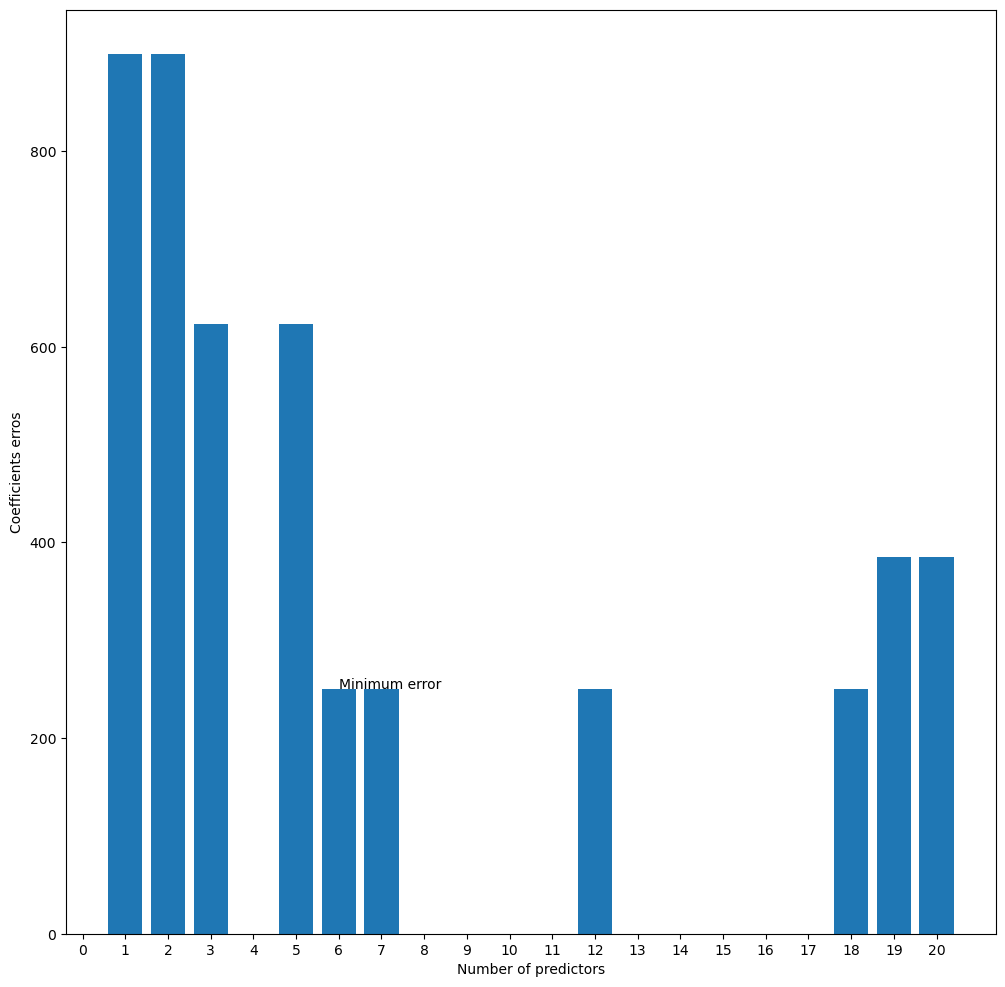

In [60]:
fig, ax = subplots(figsize=(12,12))
ax.bar(pred_num,y)
ax.set_ylabel('Coefficients erros')
ax.set_xlabel('Number of predictors')
ax.set_xticks(np.arange(max(pred_num)+1))
ax.annotate('Minimum error',(pred_num[np.argmin(y)],min(y)));

The minimum error occurs for the model with 6 predictors, while the best model is obtained with 3 predictors.<br>
Hence, a better fit of coefficients does not guarantee the lowest test MSE.

## Exercise 11

In [61]:
Boston=load_data('Boston')

In [62]:
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [63]:
Y=Boston['crim']

In [89]:
df_train,df_test = train_test_split(Boston,test_size=0.5,random_state=0)

In [90]:
#X_train=df_train.iloc[:,1:]
y_train=df_train['crim']

In [91]:
X_test=df_test.iloc[:,1:]
y_test=df_test['crim']

In [92]:
Boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


### (a)

In [93]:
# Best subset selection
design=MS(Boston.columns.drop('crim')).fit(Boston)
D=design.transform(df_train)
D = D.drop('intercept', axis=1)
X_train=np.asarray(D)
Y_train=np.asarray(y_train)
path = fit_path(X_train,Y_train,max_nonzeros=X_train.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  8
Iteration: 4. Number of non-zeros:  8
Iteration: 5. Number of non-zeros:  11
Iteration: 6. Number of non-zeros:  12


In [94]:
ones=np.ones(X_test.shape[0]).reshape(-1,1)
a=np.append(X_test,ones,axis=1)

In [95]:
iteration=[0,1,2,4,5]
pred_num=[1,2,8,11,12]
coef_list=[]
for i in iteration:
    #construct a list of arrays. Each array contains the subsets coefficients 
    coef_list.append(np.append(path[i]['B'],path[i]['B0']))
Yhat=[]
for i in range(len(iteration)):
    Yhat.append(np.matmul(a,coef_list[i]))
MSE=[]
for i in range(len(Yhat)):
    MSE.append(np.sqrt(np.mean((Yhat[i]-y_test)**2)))

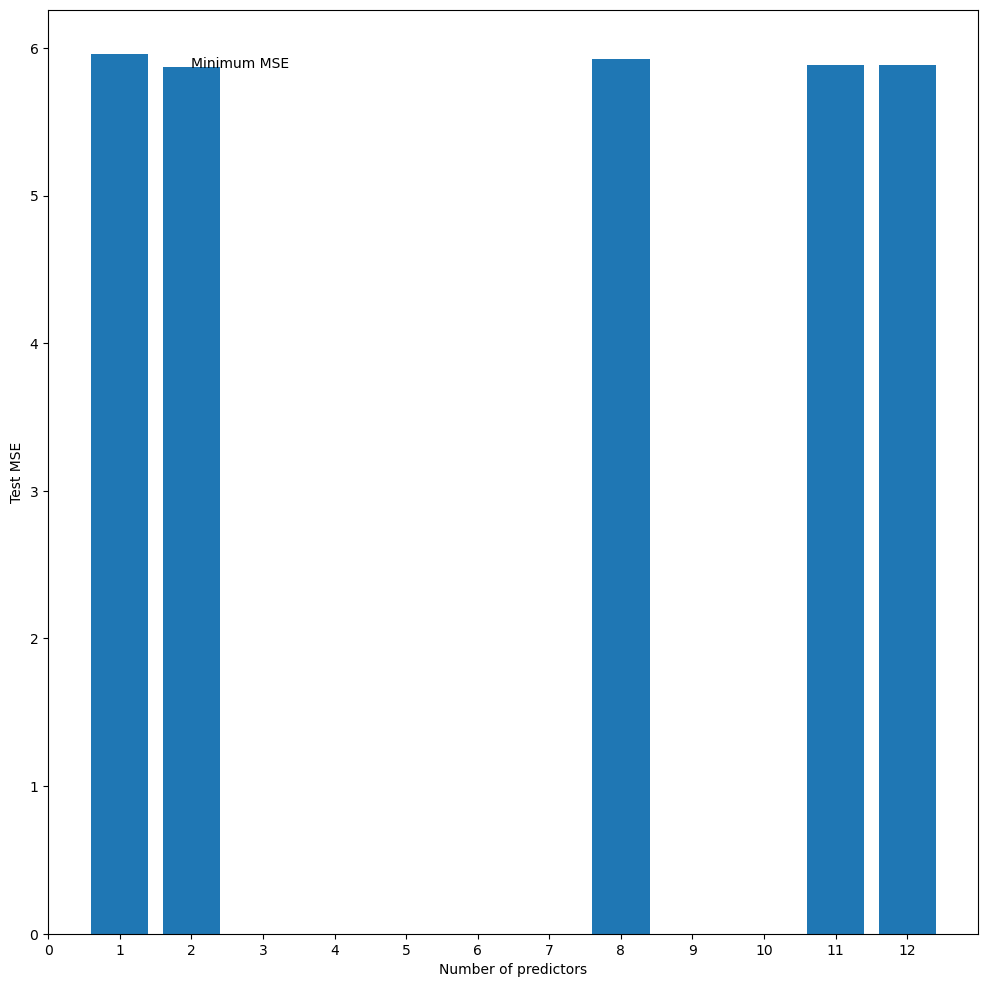

In [96]:
mse_fig, ax = subplots(figsize=(12,12))
ax.bar(pred_num,MSE)
ax.set_ylabel('Test MSE')
ax.set_xlabel('Number of predictors')
ax.set_xticks(np.arange(max(pred_num)+1))
ax.annotate('Minimum MSE',(pred_num[np.argmin(MSE)],min(MSE)));

The best subset selection method yields a model with two features.

In [97]:
# Lasso regression
# Looking for the optimal value of lambda first by cross validation
design=MS(Boston.columns.drop('crim')).fit(Boston)
D=design.transform(df_train)
X_train=np.asarray(D)
scaler = StandardScaler(with_mean=True,  with_std=True)
K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)
lassoCV = skl.ElasticNetCV(n_alphas=100,l1_ratio=1,cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),('lasso', lassoCV)])
pipeCV.fit(X_train, y_train)
tuned_lasso = pipeCV.named_steps['lasso']

print('The optimal value of lambda is:',tuned_lasso.alpha_)

The optimal value of lambda is: 0.09984441797666826


In [98]:
tuned_lasso.coef_

array([ 0.        ,  0.77398639, -0.53322203, -0.01464093, -0.        ,
        1.17122143, -0.56193997, -1.32765542,  4.25091987, -0.        ,
       -0.23738142,  1.61413872, -2.00601934])

In [99]:
X_test=design.transform(df_test)
Yhat_lasso=tuned_lasso.predict(X_test)
MSE_lasso=np.sqrt(np.mean((Yhat_lasso-y_test)**2))

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(


In [100]:
# Ridge regression
# Choose the optimal lambda for ridge regression on the training set
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
param_grid = {'ridge__alpha': lambdas}
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0,cv=kfold)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
#grid = skm.GridSearchCV(pipe,param_grid,cv=kfold,scoring='neg_mean_squared_error')
pipe.fit(X_train, y_train)

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9863.611069917239, tolerance: 1.9727224760145783
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5745.818721621197, tolerance: 1.9727224760145783
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4592.468765268715, tolerance: 1.6158217814968336
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4582.11203464633, tolerance: 1.6158217814968336
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anac

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6707.8642674508055, tolerance: 1.8163293581707616
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6575.734006641281, tolerance: 1.8163293581707616
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\an

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2526.139817353823, tolerance: 0.9793652289845876
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2516.6035622621935, tolerance: 0.9793652289845876
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\an

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7515.675897303229, tolerance: 1.9835428163132944
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\kabousselham\AppData\Local\anaconda3\Lib\

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([1.16258182e+07, 9.21326214e+06, 7.30135268e+06, 5.78619713e+06,
       4.58546228e+06, 3.63390043e+06, 2.87980395e+06, 2.28219538e+06,
       1.80860081e+06, 1.43328521e+06, 1.13585402e+06, 9.00144885e+05,
       7.13349427e+05, 5.65317222e+05, 4.48004230e+05, 3.55035691e+05,
       2.81359713e+05, 2.22972761e+05,...
       9.65195855e-02, 7.64901209e-02, 6.06171127e-02, 4.80380251e-02,
       3.80693134e-02, 3.01692798e-02, 2.39086383e-02, 1.89471870e-02,
       1.50153217e-02, 1.18993856e-02, 9.43005961e-03, 7.47316097e-03,
       5.92235227e-03, 4.69336289e-03, 3.71940983e-03, 2.94756868e-03,
       2.33589777e-03, 1.85115903e-03, 1.46701188e-03, 1.16258182e-03]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

In [101]:
tuned_ridge = pipe.named_steps['ridge']
tuned_ridge.alpha_

0.09651958548904012

In [102]:
# Fit the ridge regression
opt_lambda=tuned_ridge.alpha_
ridge_opt = skl.ElasticNet(alpha=opt_lambda, l1_ratio=0)
pipe_ridge = Pipeline(steps=[('scaler', scaler), ('ridge', ridge_opt)])
result_ridge=pipe_ridge.fit(X_train, y_train)

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.441e+03, tolerance: 2.094e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [103]:
Y_hat_ridge=result_ridge.predict(X_test)
MSE_ridge=np.sqrt(np.mean((Y_hat_ridge-y_test)**2))

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [104]:
#PCR regression
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
param_grid = {'pca__n_components': range(1, 13)}
pipe_pca=Pipeline(steps=[('scaler', scaler), ('pca', pca),('linreg', linreg)])
grid = skm.GridSearchCV(pipe_pca,param_grid,cv=kfold,scoring='neg_mean_squared_error')
pipe_pca.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('linreg', LinearRegression())])

In [105]:
grid.fit(X_train, y_train)
n_comp = param_grid['pca__n_components']
df=pd.DataFrame({'num_components':n_comp,'CV_MSE':-grid.cv_results_['mean_test_score']})
M=df['CV_MSE'].argmin(skipna=True)+1
M

9

In [106]:
pca_M = PCA(n_components=M)
linreg = skl.LinearRegression()
param_grid_M = {'pca_M__n_components': range(1, 13)}
pipe_pca_M=Pipeline(steps=[('scaler', scaler), ('pca', pca_M),('linreg', linreg)])
result_pca=pipe_pca_M.fit(X_train, y_train)

In [107]:
Yhat_pca=result_pca.predict(X_test)
MSE_pca=np.sqrt(np.mean((Yhat_pca-y_test)**2))

C:\Users\kabousselham\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [108]:
#Let's sum up the obtained results
df_results=pd.DataFrame({'Method':['Best subset','Lasso','Ridge','PCR'],'Test MSE':
                         [min(MSE),MSE_lasso,MSE_ridge,MSE_pca]})
df_results.set_index('Method')

,Test MSE
Method,
Best subset,5.868555
Lasso,46.149771
Ridge,5.865669
PCR,5.985309


### (b)

Based on the previous comparison of test MSEs, both the ridge regression on full model and the best subset selction are preferred.

### (c)

It is more preferable to choose the model obtained with the best subset selection because it is more interpretable than the Ridge regression.<br>
The chosen model involves then 2 features.